In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns


import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import log_loss, roc_auc_score, make_scorer

pd.set_option("display.max_columns",150)

import tensorflow
import xgboost

### Предобработка данных

Грузим и визуализируем данные

In [2]:
all_data = pd.read_csv("telco-customer-churn.csv")

print (all_data.shape)

for col_name in all_data.columns.values:
    all_unique = all_data[col_name].unique()
    print (col_name, len(all_unique), all_unique[0:5])

(20468, 29)
age 68 [12 42 58 20 36]
annualincome 9508 [168147  29047  27076 137977 136006]
calldroprate 8 [ 0.06  0.05  0.07  0.    0.01]
callfailurerate 4 [ 0.    0.01  0.02  0.03]
callingnum 9525 [4251078442 4251043419 4251055773 4251042488 4251073177]
customerid 9525 [1 2 3 4 5]
customersuspended 2 ['Yes' 'No']
education 4 ['Bachelor or equivalent' 'Master or equivalent' 'PhD or equivalent'
 'High School or below']
gender 2 ['Male' 'Female']
homeowner 2 ['Yes' 'No']
maritalstatus 2 ['Single' 'Married']
monthlybilledamount 120 [71  8 16 74 81]
noadditionallines 1 ['\\N']
numberofcomplaints 4 [0 1 3 2]
numberofmonthunpaid 8 [7 4 2 5 0]
numdayscontractequipmentplanexpiring 100 [96 14 55 73 32]
occupation 3 ['Technology Related Job' 'Non-technology Related Job' 'Others']
penaltytoswitch 500 [371  43 403  76 436]
state 50 ['WA' 'WI' 'KS' 'KY' 'ND']
totalminsusedinlastmonth 500 [ 15 212 216 412 416]
unpaidbalance 250 [ 19  34 144 159 143]
usesinternetservice 2 ['No' 'Yes']
usesvoiceservic

Функция отрисовывает процент churn для выбранной переменной

In [3]:
def plot_col (col_name):
    try:
        dt_plot = all_data.groupby(col_name).agg({'age':'count', 'churn': 'sum'}).reset_index().rename(columns={'age':'rec_count'})
    except: ## for age column
        dt_plot = all_data.groupby(col_name).agg({'annualincome':'count', 'churn': 'sum'}).reset_index().rename(columns={'annualincome':'rec_count'})
        
    ## for string columns
    if type(dt_plot[col_name][0]) is str:
        aa = LabelEncoder()
        dt_plot[col_name] = aa.fit_transform(dt_plot[col_name])
        
    dt_plot['churn_perc'] = dt_plot['churn'] / dt_plot['rec_count']
    print (dt_plot.head())

    plt.plot(dt_plot[col_name],dt_plot['churn_perc'])
    plt.show()


Заметна аномалия при анализе влияния возраста на churn rate

   age  rec_count  churn  churn_perc
0   12        317     49    0.154574
1   13        294     37    0.125850
2   14        312     47    0.150641
3   15        311     42    0.135048
4   16        295     39    0.132203


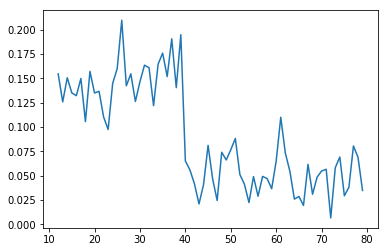

In [141]:
plot_col('age')

Нет зависимости между доходом пользователя и его уровнем образования.

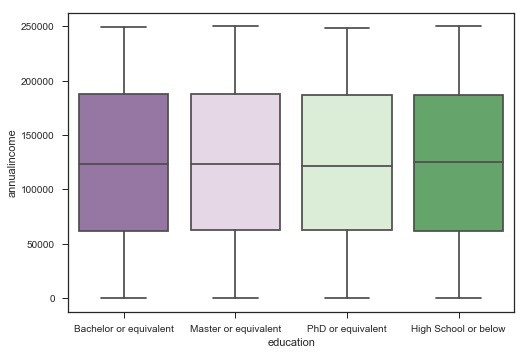

In [19]:
sns.boxplot(x="education", y="annualincome", data=all_data, palette="PRGn")


Также нет зависимости между доходом и полом

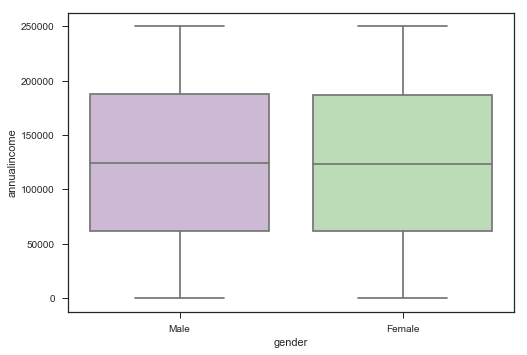

In [20]:
sns.boxplot(x="gender", y="annualincome", data=all_data, palette="PRGn")


Также не видна зависимости между возрастом и доходом абонента.

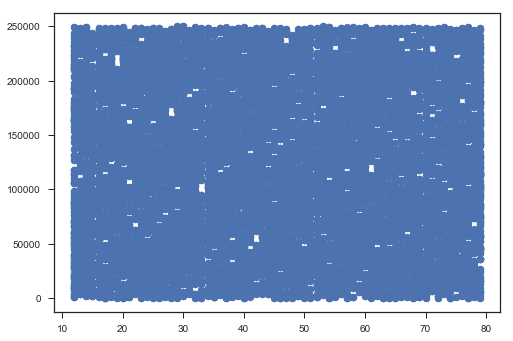

In [22]:
plt.scatter(all_data['age'],all_data['annualincome'])
plt.show()

   education  rec_count  churn  churn_perc
0          0       6138    599    0.097589
1          1      10217    934    0.091416
2          2       3099    226    0.072927
3          3       1014    104    0.102564


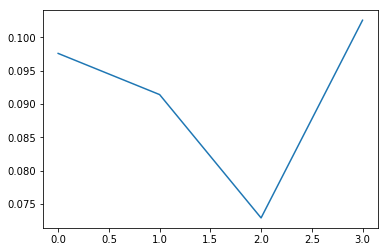

In [137]:
plot_col('education')

Добавим средние, максимумы и минимумы по звонкам для каждого номероа

In [48]:
dt_mean = all_data.groupby(['callingnum'])['totalcallduration','avgcallduration'].mean()
dt_mean.columns = [x+'_mean' for x in dt_mean.columns.values]


dt_max = all_data.groupby(['callingnum'])['totalcallduration','avgcallduration'].max()
dt_max.columns = [x+'_max' for x in dt_max.columns.values]


dt_min = all_data.groupby(['callingnum'])['totalcallduration','avgcallduration'].min()
dt_min.columns = [x+'_min' for x in dt_min.columns.values]

aa = dt_mean.join(dt_max).join(dt_min)
all_data = all_data.set_index('callingnum').join(aa)
all_data = all_data.reset_index()

Удаляем колонки с годом, месяцев и номером телефона. Они не должны влиять на уровень churn. Но будем иметь в виду, что данные для каждого номера даны за несколько месяцев.

In [53]:
all_data.drop(['year','month','callingnum','customerid','noadditionallines'],axis=1,inplace=True)

Обрабатываем бинарные переменные

In [54]:
bin_cols = ['customersuspended','gender','homeowner','maritalstatus','usesinternetservice','usesvoiceservice']
for col_name in bin_cols:
    unique_val = all_data[col_name].unique()[0]
    all_data[col_name+"__"+unique_val] = 0
    all_data.loc[all_data[col_name]==unique_val,col_name+"__"+unique_val] = 1
    all_data.drop(col_name, axis = 1, inplace=True)

Обрабатываем остальные категорийные переменные

In [55]:
cd_cols = ['education','occupation','state']
all_data_cat = []
for col_name in cd_cols:
    aa = pd.get_dummies(all_data[col_name])
    aa.columns = [col_name+"__"+x for x in aa.columns.values]
    all_data_cat.append(aa)
all_data_cat = pd.concat(all_data_cat,axis=1)

In [56]:
all_data.drop(['education','occupation','state'],axis=1,inplace=True)
all_data = pd.concat([all_data,all_data_cat],axis=1)
print (all_data.shape)

(20468, 84)


### Создаём модель

Для оценки качества модели будем использовать negative log-loss и ROC-AUC. Тренировать модели будем на log-loss.


Делаем K-fold кросс валидацию

In [59]:
X = all_data.drop('churn',axis=1).copy(deep=True)
y = np.array(all_data['churn'])

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.30, random_state=101,shuffle=True)
kf = KFold(n_splits=4,random_state=102)

print (np.sum(y),np.sum(y_train),np.sum(y_valid))

1863 1312 551


#### Регрессия Риджа

ROC AUC: 0.647715803131 <br>
Neg log loss: -


In [60]:
rdg = Ridge(alpha=1.0, fit_intercept=True, normalize = False, max_iter = 10)
cv_score = cross_val_score(rdg, X_train, y_train, cv = kf, n_jobs = -1, scoring = 'roc_auc')

print (cv_score, np.mean(cv_score))

[ 0.68103004  0.64755534  0.67429992  0.65704768] 0.664983245138


In [61]:
print (cv_score, np.mean(cv_score))

[ 0.68103004  0.64755534  0.67429992  0.65704768] 0.664983245138


#### Деревья решений

ROC AUC: 0.973622 <br>
Neg log loss: 0.095319

In [65]:
et_clf = ExtraTreesClassifier(n_estimators = 100, criterion = 'entropy',max_depth=None,
                              min_samples_leaf = 1, random_state = 103, n_jobs=-1)

et_clf.fit(X_train,y_train)

y_pred = et_clf.predict_proba(X_valid)
y_pred = [x[1] for x in y_pred]
print ("")
print ("ROC AUC: %f " % roc_auc_score(y_valid,y_pred))
print ("Neg log loss: %f " % log_loss(y_valid,y_pred))


ROC AUC: 0.972237 
Neg log loss: 0.094556 


Анализ значимых переменных. Среди значимых переменных - numberofcomplaints, callfailurerate, unpaidbalance. Это соответствует бизнес смыслу.

In [68]:
importances = et_clf.feature_importances_
indices = np.argsort(importances[::-1])

tree_cols = X_train.columns.values[indices]
for k, indx in enumerate(indices[:30]):
    print ("%d. feature %s (%f)" % (k,tree_cols[indx], importances[indx]))

0. feature numberofcomplaints (0.030945)
1. feature state__AR (0.021303)
2. feature totalcallduration (0.004194)
3. feature education__Bachelor or equivalent (0.029504)
4. feature state__DE (0.032739)
5. feature state__IL (0.003931)
6. feature callfailurerate (0.013532)
7. feature occupation__Others (0.013411)
8. feature unpaidbalance (0.004259)
9. feature totalminsusedinlastmonth (0.003397)
10. feature percentagecalloutsidenetwork (0.011144)
11. feature numdayscontractequipmentplanexpiring (0.006394)
12. feature totalcallduration_min (0.014584)
13. feature totalcallduration_mean (0.008544)
14. feature state__NH (0.029401)
15. feature totalcallduration_max (0.005557)
16. feature calldroprate (0.005331)
17. feature state__ND (0.005821)
18. feature state__CO (0.002673)
19. feature maritalstatus__Married (0.012722)
20. feature state__IN (0.031607)
21. feature usesinternetservice__No (0.003853)
22. feature avgcallduration_mean (0.004314)
23. feature customersuspended__Yes (0.005885)
24. fe

На кроссвалидации модель показывает неплохой результат

ROC AUC: 0.936012447263 <br>
Neg log loss: 0.138042290993

In [69]:
ll_scorer = make_scorer(log_loss,greater_is_better = False,needs_proba=True)
cv_score = cross_val_score(et_clf, X_train, y_train, cv = kf, n_jobs = -1, scoring = ll_scorer)

print (cv_score, np.mean(cv_score))

[-0.13747529 -0.13459111 -0.12983358 -0.15026918] -0.138042290993


In [70]:
cv_score = cross_val_score(et_clf, X_train, y_train, cv = kf, n_jobs = -1, scoring = 'roc_auc')

print (cv_score, np.mean(cv_score))

[ 0.94570929  0.94266742  0.9401467   0.91552637] 0.936012447263


#### Xgboost

ROC AUC: 0.941521  <br>
Neg log loss: 0.114619  

In [74]:
import xgboost as xgb

X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(X_train, y_train, test_size=0.3, random_state=101)

##dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
##dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

dtrain = xgb.DMatrix(X_train, label=y_train)
## dtest = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

evallist = [(dtrain,'train'),(dvalid, 'valid')]


param = {'max_depth': 8, 'eta': 0.1, 'silent': 1, 'objective': 'binary:logistic',
        'eval_metric':'logloss','nthread':4, 'subsample':0.7,'seed':11}

num_round = 50000
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds = 10)

xgb_pred = bst.predict(dvalid)

print ("")
print ("ROC AUC: %f " % roc_auc_score(y_valid,xgb_pred))
print ("Neg log loss: %f " % log_loss(y_valid,xgb_pred))


[0]	train-logloss:0.624836	valid-logloss:0.627236
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[1]	train-logloss:0.568648	valid-logloss:0.57275
[2]	train-logloss:0.521075	valid-logloss:0.526835
[3]	train-logloss:0.48116	valid-logloss:0.488529
[4]	train-logloss:0.446556	valid-logloss:0.456337
[5]	train-logloss:0.417118	valid-logloss:0.428391
[6]	train-logloss:0.391428	valid-logloss:0.404346
[7]	train-logloss:0.369147	valid-logloss:0.383712
[8]	train-logloss:0.34881	valid-logloss:0.365157
[9]	train-logloss:0.33125	valid-logloss:0.349116
[10]	train-logloss:0.316465	valid-logloss:0.335701
[11]	train-logloss:0.303639	valid-logloss:0.323767
[12]	train-logloss:0.290717	valid-logloss:0.312782
[13]	train-logloss:0.27869	valid-logloss:0.302885
[14]	train-logloss:0.268144	valid-logloss:0.294287
[15]	train-logloss:0.259316	valid-logloss:0.286956
[16]	train-logloss:0.249864	valid-logloss:0.2801

[158]	train-logloss:0.04023	valid-logloss:0.132874
[159]	train-logloss:0.040027	valid-logloss:0.132688
[160]	train-logloss:0.039673	valid-logloss:0.132155
[161]	train-logloss:0.039403	valid-logloss:0.131839
[162]	train-logloss:0.038877	valid-logloss:0.131225
[163]	train-logloss:0.038284	valid-logloss:0.130942
[164]	train-logloss:0.037957	valid-logloss:0.130555
[165]	train-logloss:0.037805	valid-logloss:0.130542
[166]	train-logloss:0.037492	valid-logloss:0.130207
[167]	train-logloss:0.037091	valid-logloss:0.130068
[168]	train-logloss:0.036644	valid-logloss:0.129726
[169]	train-logloss:0.036455	valid-logloss:0.129539
[170]	train-logloss:0.03612	valid-logloss:0.129582
[171]	train-logloss:0.035864	valid-logloss:0.129341
[172]	train-logloss:0.035344	valid-logloss:0.129199
[173]	train-logloss:0.035081	valid-logloss:0.129119
[174]	train-logloss:0.034926	valid-logloss:0.128853
[175]	train-logloss:0.03459	valid-logloss:0.128684
[176]	train-logloss:0.03434	valid-logloss:0.128685
[177]	train-logl

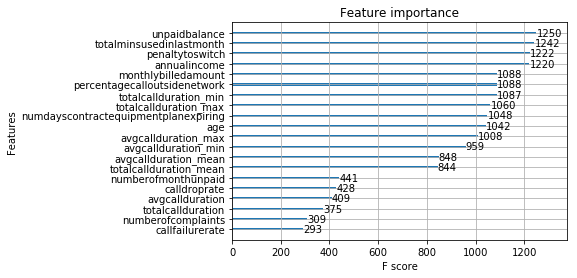

In [75]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(bst, max_num_features = 20)
pyplot.show()


Посмотрим результат оптимизации для xgboost на кроссвалидации

ROC AUC: 0.896042862549 <br>
Neg log loss: 0.170526451059

In [72]:
xgb_preds=[]

for train_index, test_index in kf.split(X_train):
    print (train_index)
    dtrain = xgb.DMatrix(X_train.iloc[train_index], label=y_train[train_index])
    ## dtest = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_train.iloc[test_index], label=y_train[test_index])

    param = {'max_depth': 10, 'eta': 0.1, 'silent': 1,'colsample_bytree': 0.5,
             'objective': 'binary:logistic','alpha':0.3,
            'eval_metric':'logloss','nthread':4, 'subsample':1,'seed':11,'silent':True,
            'verbose':0}
    num_round = 50000
    
    bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds = 10)

    xgb_pred = bst.predict(dvalid)

    rc_auc =  roc_auc_score(y_train[test_index], xgb_pred) 
    ll =  log_loss(y_train[test_index],xgb_pred)

    xgb_preds.append([rc_auc,ll])
    print ("")
    print ("ROC AUC: %f " % rc_auc)
    print ("Neg log loss: %f " % ll)
    
print (xgb_preds)
print (np.mean([x[0] for x in xgb_preds]))
print (np.mean([x[1] for x in xgb_preds]))

[ 3582  3583  3584 ..., 14324 14325 14326]
[0]	train-logloss:0.627861	valid-logloss:0.628812
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[1]	train-logloss:0.573104	valid-logloss:0.575069
[2]	train-logloss:0.527783	valid-logloss:0.53075
[3]	train-logloss:0.491049	valid-logloss:0.49457
[4]	train-logloss:0.457012	valid-logloss:0.462284
[5]	train-logloss:0.426343	valid-logloss:0.433945
[6]	train-logloss:0.402735	valid-logloss:0.411479
[7]	train-logloss:0.378997	valid-logloss:0.390055
[8]	train-logloss:0.359107	valid-logloss:0.371896
[9]	train-logloss:0.342467	valid-logloss:0.356947
[10]	train-logloss:0.324973	valid-logloss:0.341753
[11]	train-logloss:0.312089	valid-logloss:0.330398
[12]	train-logloss:0.298642	valid-logloss:0.318807
[13]	train-logloss:0.283641	valid-logloss:0.307153
[14]	train-logloss:0.274187	valid-logloss:0.299069
[15]	train-logloss:0.264972	valid-logloss:0.291856
[1

[1]	train-logloss:0.572719	valid-logloss:0.575039
[2]	train-logloss:0.526547	valid-logloss:0.530856
[3]	train-logloss:0.488186	valid-logloss:0.493905
[4]	train-logloss:0.454081	valid-logloss:0.461504
[5]	train-logloss:0.422843	valid-logloss:0.432293
[6]	train-logloss:0.398027	valid-logloss:0.409214
[7]	train-logloss:0.374348	valid-logloss:0.387446
[8]	train-logloss:0.353483	valid-logloss:0.368993
[9]	train-logloss:0.335976	valid-logloss:0.353401
[10]	train-logloss:0.319725	valid-logloss:0.338852
[11]	train-logloss:0.307371	valid-logloss:0.327868
[12]	train-logloss:0.294987	valid-logloss:0.316952
[13]	train-logloss:0.282201	valid-logloss:0.30667
[14]	train-logloss:0.27286	valid-logloss:0.298936
[15]	train-logloss:0.262655	valid-logloss:0.290795
[16]	train-logloss:0.253603	valid-logloss:0.284072
[17]	train-logloss:0.246508	valid-logloss:0.278447
[18]	train-logloss:0.241325	valid-logloss:0.27391
[19]	train-logloss:0.236794	valid-logloss:0.270223
[20]	train-logloss:0.228503	valid-logloss:0

[1]	train-logloss:0.572494	valid-logloss:0.575144
[2]	train-logloss:0.526598	valid-logloss:0.530603
[3]	train-logloss:0.48988	valid-logloss:0.494655
[4]	train-logloss:0.455663	valid-logloss:0.462352
[5]	train-logloss:0.424648	valid-logloss:0.43342
[6]	train-logloss:0.400217	valid-logloss:0.410276
[7]	train-logloss:0.376635	valid-logloss:0.388429
[8]	train-logloss:0.356532	valid-logloss:0.370203
[9]	train-logloss:0.339332	valid-logloss:0.354822
[10]	train-logloss:0.322095	valid-logloss:0.339992
[11]	train-logloss:0.308983	valid-logloss:0.328602
[12]	train-logloss:0.296742	valid-logloss:0.31786
[13]	train-logloss:0.282584	valid-logloss:0.306568
[14]	train-logloss:0.273512	valid-logloss:0.298894
[15]	train-logloss:0.264065	valid-logloss:0.291496
[16]	train-logloss:0.25571	valid-logloss:0.284836
[17]	train-logloss:0.248501	valid-logloss:0.279363
[18]	train-logloss:0.24155	valid-logloss:0.274494
[19]	train-logloss:0.236264	valid-logloss:0.270558
[20]	train-logloss:0.229302	valid-logloss:0.2

[162]	train-logloss:0.058716	valid-logloss:0.159418
[163]	train-logloss:0.058691	valid-logloss:0.159454
[164]	train-logloss:0.058617	valid-logloss:0.159413
[165]	train-logloss:0.058404	valid-logloss:0.159357
[166]	train-logloss:0.05836	valid-logloss:0.159374
[167]	train-logloss:0.058051	valid-logloss:0.159138
[168]	train-logloss:0.057981	valid-logloss:0.159091
[169]	train-logloss:0.057935	valid-logloss:0.159116
[170]	train-logloss:0.057732	valid-logloss:0.158945
[171]	train-logloss:0.057516	valid-logloss:0.158799
[172]	train-logloss:0.057334	valid-logloss:0.158812
[173]	train-logloss:0.057119	valid-logloss:0.158804
[174]	train-logloss:0.057015	valid-logloss:0.158855
[175]	train-logloss:0.056903	valid-logloss:0.158917
[176]	train-logloss:0.056735	valid-logloss:0.158787
[177]	train-logloss:0.056672	valid-logloss:0.158893
[178]	train-logloss:0.05649	valid-logloss:0.158966
[179]	train-logloss:0.056429	valid-logloss:0.159021
[180]	train-logloss:0.056254	valid-logloss:0.158958
[181]	train-lo

[130]	train-logloss:0.067322	valid-logloss:0.164592
[131]	train-logloss:0.066943	valid-logloss:0.164508
[132]	train-logloss:0.066715	valid-logloss:0.164554
[133]	train-logloss:0.066513	valid-logloss:0.164514
[134]	train-logloss:0.066347	valid-logloss:0.16457
[135]	train-logloss:0.065863	valid-logloss:0.164378
[136]	train-logloss:0.06568	valid-logloss:0.164273
[137]	train-logloss:0.065592	valid-logloss:0.164371
[138]	train-logloss:0.065334	valid-logloss:0.164219
[139]	train-logloss:0.065089	valid-logloss:0.164193
[140]	train-logloss:0.064986	valid-logloss:0.164265
[141]	train-logloss:0.064805	valid-logloss:0.164127
[142]	train-logloss:0.064672	valid-logloss:0.164127
[143]	train-logloss:0.064564	valid-logloss:0.16417
[144]	train-logloss:0.064357	valid-logloss:0.164096
[145]	train-logloss:0.064136	valid-logloss:0.163894
[146]	train-logloss:0.063897	valid-logloss:0.163877
[147]	train-logloss:0.063788	valid-logloss:0.163878
[148]	train-logloss:0.063705	valid-logloss:0.163896
[149]	train-log

#### Keras model

ROC AUC: 0.710062     
Neg log loss: 0.297977  

In [89]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from keras.callbacks import EarlyStopping

import keras.backend as K
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train)
X_train_ker = ss.transform(X_train)
X_valid_ker = ss.transform(X_valid)

ker_model = Sequential()
ker_model.add(Dense(20, input_dim=83, activation='relu',kernel_initializer='uniform'))
ker_model.add(Dropout(0))
ker_model.add(Dense(10, activation='relu',kernel_initializer='uniform'))
ker_model.add(Dropout(0))
ker_model.add(Dense(1, activation='sigmoid',kernel_initializer='uniform'))


early_stopping_monitor = EarlyStopping(patience=10)


## binary_crossentropy
ker_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

ker_model.fit(X_train_ker, y_train,
        callbacks=[early_stopping_monitor],
        validation_split = 0.25,
          epochs=500,
          batch_size=64,
             verbose = 2)

score = ker_model.evaluate(X_valid_ker, y_valid, batch_size=128)
print (score)

pred_proba = ker_model.predict_proba(X_train_ker)

print ("")
print ("ROC AUC: %f " % roc_auc_score(y_train,pred_proba))
print ("Neg log loss: %f " % log_loss(y_train,pred_proba))


pred_proba = ker_model.predict_proba(X_valid_ker)

print ("")
print ("ROC AUC: %f " % roc_auc_score(y_valid,pred_proba))
print ("Neg log loss: %f " % log_loss(y_valid,pred_proba))

Train on 10745 samples, validate on 3582 samples
Epoch 1/500
 - 1s - loss: 0.4752 - acc: 0.9028 - val_loss: 0.2952 - val_acc: 0.9090
Epoch 2/500
 - 1s - loss: 0.2896 - acc: 0.9082 - val_loss: 0.2896 - val_acc: 0.9090
Epoch 3/500
 - 1s - loss: 0.2819 - acc: 0.9082 - val_loss: 0.2892 - val_acc: 0.9090
Epoch 4/500
 - 0s - loss: 0.2781 - acc: 0.9082 - val_loss: 0.2884 - val_acc: 0.9090
Epoch 5/500
 - 1s - loss: 0.2745 - acc: 0.9082 - val_loss: 0.2881 - val_acc: 0.9090
Epoch 6/500
 - 0s - loss: 0.2713 - acc: 0.9082 - val_loss: 0.2880 - val_acc: 0.9090
Epoch 7/500
 - 1s - loss: 0.2680 - acc: 0.9082 - val_loss: 0.2879 - val_acc: 0.9090
Epoch 8/500
 - 0s - loss: 0.2649 - acc: 0.9082 - val_loss: 0.2860 - val_acc: 0.9090
Epoch 9/500
 - 0s - loss: 0.2609 - acc: 0.9082 - val_loss: 0.2863 - val_acc: 0.9090
Epoch 10/500
 - 1s - loss: 0.2578 - acc: 0.9082 - val_loss: 0.2861 - val_acc: 0.9090
Epoch 11/500
 - 0s - loss: 0.2541 - acc: 0.9081 - val_loss: 0.2849 - val_acc: 0.9090
Epoch 12/500
 - 0s - loss

### Анализ полученных результатов

Было построено четыре модели: Регрессия Риджа, ExtraTrees, xgboost и нейронная сеть. Из всех моделей наилучшую предиктивную способности показали ExtraTrees. На втором месте xgboost. Поэтому для промышленного решения рекомендую использовать ExtraTrees или xgboost, в зависимости от того, что окажется более робастным при анализе вероятности оттока во времени.

При анализе данных обнаружилась аномалия в данных по возрасту. Churn rate резко падает для пользователей старше 40 лет. Данная аномалия требует дальнейшего анализа. В данный момент модель может оказаться смещённой в сторону пользователей младше 40 лет.

Кроме того в данных не видны зависимости между возрастом и доходом, полом и доходом, уровнем образования и доходом. Из этого можно сделать вывод, что данные, возможно, созданы искусственно. Данные наблюдения требуют дальнейшего анализа. 

Пока вопросы, вызванные аномалиями, не будут решены, модель нельзя выводить в промышленную эксплуатацию. 